In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [31]:
def rotation_matrix_y(theta):
    s = np.sin(theta)
    c = np.cos(theta)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])

def get_bbox3d_to_img(label_obj, P):
    """ 
    Args:
    label_obj: Object of label data
    P: 3x4 projection matrix (project pts in camera system to image plane)

    Get points of 3d bounding box in below order:
            7 -------- 4
           /|         /|
          6 -------- 5 .
          | |        | |
          . 3 -------- 0
          |/         |/
          2 -------- 1
    """
    h, w, l = label_obj.h, label_obj.w, label_obj.l

    x_corners = np.array([l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2])
    y_corners = np.array([0, 0, 0, 0, -h, -h, -h, -h])
    z_corners = np.array([w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2])
    bbx3d_pts = np.vstack([x_corners, y_corners, z_corners])

    # calculate 3d bounding box coordinates in the camera system
    rot_mat = rotation_matrix_y(label_obj.ry)
    bbx3d_pts = (rot_mat @ bbx3d_pts).T + label_obj.coords # 8x3

    # we don't consider objects in the back of the camera
    if bbx3d_pts[:, 2].any() < 0.1:
        bbx_2d = None

    # project 3d bounding box into image plane
    bbx3d_pts_h = np.hstack([bbx3d_pts, np.ones([bbx3d_pts.shape[0], 1])]) # 8x4
    bbx_2d = (P @ bbx3d_pts_h.T).T # 8x3
    bbx_2d[:, 0] /= bbx_2d[:, 2]
    bbx_2d[:, 1] /= bbx_2d[:, 2]

    return bbx_2d[:, :2].astype(int)

def draw_bbx_3d(bbx_2d, img, color=(0, 0, 0), thickness=2):
    '''
    Keep the same order as how to create 3d bbx
    '''

    for k in range(0, 4):
        # draw the bottom rectangle
        i, j = k, (k + 1) % 4
        cv2.line(img, (bbx_2d[i, 0], bbx_2d[i, 1]), (bbx_2d[j, 0], bbx_2d[j, 1]), color, thickness)

        # draw the top rectangle
        i, j = k + 4, (k + 1) % 4 + 4
        cv2.line(img, (bbx_2d[i, 0], bbx_2d[i, 1]), (bbx_2d[j, 0], bbx_2d[j, 1]), color, thickness)

        # draw the vertical lines
        i, j = k, k + 4
        cv2.line(img, (bbx_2d[i, 0], bbx_2d[i, 1]), (bbx_2d[j, 0], bbx_2d[j, 1]), color, thickness)
    return img

In [34]:
class KittiCalib:
    def __init__(self, root):
        calib_data = self.read_calib(root)
        self.P2 = np.array(calib_data['P2']).reshape(3, 4)
        self.P3 = np.array(calib_data['P3']).reshape(3, 4)
        self.R0 = np.array(calib_data['R0_rect']).reshape(3, 3)

        # camera intrinsics and extrinsics
        self.fx = self.P2[0, 0]
        self.fy = self.P2[1, 1]
        self.cx = self.P2[0, 2]
        self.cy = self.P2[1, 2]
        self.tx = self.P2[0, 3]
        self.ty = self.P2[1, 3]

    def read_calib(self, root):
        calib_data = {}
        with open(root, 'r') as f:
            for line in f.readlines():
                # check if the line is not empty after stripping all the whitespace
                if line.strip():
                    line = line.rstrip()
                    key, value = line.split(':')
                    calib_data[key] = [float(val) for val in value.split()]
                else:
                    break
        return calib_data
    

class Object3d:
    def __init__(self, data_line):
        data = data_line.split()
        data[1:] = [float(x) for x in data[1:]]

        self.type = data[0]
        self.truncated = data[1] # truncated pixel ratio [0..1]
        self.occluded = int(data[2]) # 0 = visible, 1 = partly occluded, 2 = fully occluded, 3 = unknown
        self.alpha = data[3] # observation angle [-pi..pi]

        # 2d bounding box
        self.xmin = data[4]  
        self.ymin = data[5]  
        self.xmax = data[6]  
        self.ymax = data[7]
        self.bbx2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # 3d bbx
        self.h = data[8]
        self.w = data[9]
        self.l = data[10]
        self.coords = np.array([data[11], data[12], data[13]]) # coordinates (x, y, z) of object center in camera coordinate system
        self.ry = data[14] # yaw angle [-pi, pi] in camera coords system
    

def read_label(root):
    '''
    read label_2 data
    '''
    label_data = []
    with open(root, 'r') as f:
        for line in f.readlines():
            if line.strip():
                line = line.rstrip()
                label_data.append(Object3d(line))
            else:
                break
    return label_data

class KittiObject:
    def __init__(self, data_dir, split='training'):
        self.data_dir = data_dir
        self.split_dir = os.path.join(self.data_dir, split)

        # create data path
        self.image_path = os.path.join(self.split_dir, 'image_2')
        self.calib_path = os.path.join(self.split_dir, 'calib')
        self.label_path = os.path.join(self.split_dir, 'label_2')
        self.pc_path = os.path.join(self.split_dir, 'velodyne')

    def get_image(self, idx):
        image_name = os.listdir(self.image_path)[idx]
        img = cv2.imread(os.path.join(self.image_path, image_name))
        return img
    
    def get_calib(self, idx):
        calib_file_name = os.listdir(self.calib_path)[idx]
        calib_path = os.path.join(self.calib_path, calib_file_name)

        return KittiCalib(calib_path)
    
    def get_label(self, idx):
        label_file_name = os.listdir(self.label_path)[idx]
        label_path = os.path.join(self.label_path, label_file_name)
        return read_label(label_path)
        

In [35]:
data_path = 'data/KITTI/object/'
split = 'training'

kt_obj = KittiObject(data_path, split)
img = kt_obj.get_image(0)
calib = kt_obj.get_calib(0)
label = kt_obj.get_label(0)

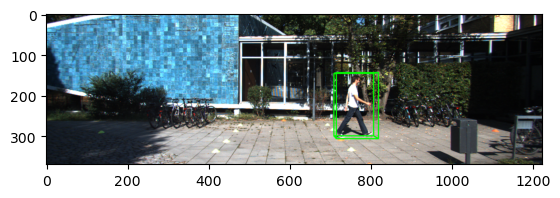

In [42]:
bbx_2d = get_bbox3d_to_img(label[0], calib.P2)
img = draw_bbx_3d(bbx_2d, img, (0, 255, 0))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)